In [1]:
## install
# !pip install xgboost

In [2]:
## import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.nn import DataParallel
from torch.utils.data import DataLoader, TensorDataset
from itertools import cycle

In [3]:
## variables
seed = 42
ratio_test = 0.2
exp_name = 'exp10'
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
## class
class InvariantModel(nn.Module):
    def __init__(self, len_embedding, abstract_len_embedding):
        super(InvariantModel, self).__init__()
        self.loss = nn.L1Loss(reduction="mean") 
        self.len_embedding = len_embedding
        self.abstract_len_embedding = abstract_len_embedding  
        self.encoder = nn.Sequential(
            ## 1024 to 2048
            nn.Linear(self.len_embedding, int(self.len_embedding*0.875)),
            nn.ReLU(),
            nn.BatchNorm1d(int(self.len_embedding*0.875)), 
            ## 2048 to 1536
            nn.Linear(int(self.len_embedding*0.875), int(self.len_embedding*0.75)),
            nn.ReLU(),
            nn.BatchNorm1d(int(self.len_embedding*0.75)),
            ## 1536 to 1024
            nn.Linear(int(self.len_embedding*0.75), self.abstract_len_embedding),
        )        
        self.head1 = nn.Linear(self.abstract_len_embedding, 1)  # For dataset 1
        self.head2 = nn.Linear(self.abstract_len_embedding, 1)  # For dataset 2
        self.head3 = nn.Linear(self.abstract_len_embedding*2, 1) # For pair training 

    def forward(self, x, dataset_id, x2=None):
        x = self.encoder(x)
        if dataset_id == 1:
            return self.head1(x)
        elif dataset_id == 2:
            return self.head2(x)
        elif dataset_id == 3 and x2 is not None:
            x2 = self.encoder(x2)
            x_combined = torch.cat((x, x2), dim=1)  # Concatenate the encoded features
            return self.head3(x_combined)
        else:
            pass  # Handle error or return None

In [5]:
## function

def get_model_invariant(train_loader1, train_loader2, len_embedding, abstract_len_embedding):    
    print(f'len_embedding: {len_embedding}, abstract_len_embedding: {abstract_len_embedding}')
    
    _lr, num_iterations = 1e-3, 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_invariant = InvariantModel(len_embedding, abstract_len_embedding)
    if torch.cuda.is_available():
        model_invariant = DataParallel(model_invariant)
    model_invariant.to(device)
    optimizer_invariant = torch.optim.Adam(model_invariant.parameters(), lr=_lr)

    model_invariant.train()
    for epoch in range(num_iterations):
        total_loss = 0.0

        # Cycle through the smaller dataset
        train_loader1_cycle = cycle(train_loader1)
        train_loader2_cycle = cycle(train_loader2)

        # Determine the maximum number of batches between the two datasets
        max_batches = max(len(train_loader1), len(train_loader2))

        for i in range(max_batches):
            # Get batch from each dataset; cycle the smaller dataset
            data1 = next(train_loader1_cycle)
            data2 = next(train_loader2_cycle)

            optimizer_invariant.zero_grad()

            # Process dataset 1
            inputs1, labels1 = data1[0].to(device), data1[1].to(device)
            outputs1 = model_invariant(inputs1, dataset_id=1).squeeze()
            loss1 = model_invariant.module.loss(outputs1, labels1) if isinstance(model_invariant, DataParallel) else model_invariant.loss(outputs1, labels1)            
            loss1.backward()

            # Process dataset 2
            inputs2, labels2 = data2[0].to(device), data2[1].to(device)
            outputs2 = model_invariant(inputs2, dataset_id=2).squeeze()
            loss2 = model_invariant.module.loss(outputs2, labels2) if isinstance(model_invariant, DataParallel) else model_invariant.loss(outputs2, labels2)            
            loss2.backward()

            # Process pair training (dataset 1 and 2 combined)
            min_batch_size = min(inputs1.size(0), inputs2.size(0))
            if inputs1.size(0) != inputs2.size(0):
                # Truncate inputs to the smaller batch size
                inputs1_truncated = inputs1[:min_batch_size]
                inputs2_truncated = inputs2[:min_batch_size]
                pair_labels = labels1[:min_batch_size] - labels2[:min_batch_size]
            else:
                inputs1_truncated = inputs1
                inputs2_truncated = inputs2
                pair_labels = labels1 - labels2
            outputs3 = model_invariant(inputs1_truncated, dataset_id=3, x2=inputs2_truncated).squeeze()
            loss3 = model_invariant.module.loss(outputs3, pair_labels) if isinstance(model_invariant, DataParallel) else model_invariant.loss(outputs3, pair_labels)
            loss3.backward()
            
            optimizer_invariant.step()
            
            total_loss += (loss1.item()+loss2.item()+loss3.item())


        if epoch % 1 == 0:
            with open('v2_script_10/logger_' + exp_name + '.log', 'a+') as file1:
                file1.writelines(f'epoch: {epoch}, total_loss: {total_loss:.6f}\n\n')
                
    return model_invariant

In [6]:
## check for word ('cathub/ocp', 'nre/energy', 'original/pca')
## common (dimenet++, Two-Functional-Model, xgboost) 
## (cathub/ocp x org/pca/imr x MAE/r2) 

In [7]:
## 5. cathub, imr, (MAE, r2)
## 6. ocp, imr, (MAE, r2)

df1 = pd.read_pickle(f'datasets/df_cathub_dpp_combined.pickle')
X1 = df1.iloc[:, :-1].values
y1 = df1['nre'].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=ratio_test, random_state=seed)
df2 = pd.read_pickle(f'datasets/df_ocp_dpp_combined.pickle')
X2 = df2.iloc[:, :-1].values
y2 = df2['energy'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=ratio_test, random_state=seed)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(8750, 1024) (2188, 1024) (8750,) (2188,)
(263890, 1024) (65973, 1024) (263890,) (65973,)


In [8]:
# Convert to PyTorch Tensors
train_data1 = TensorDataset(torch.tensor(X_train1, dtype=torch.float32), torch.tensor(y_train1, dtype=torch.float32))
train_data2 = TensorDataset(torch.tensor(X_train2, dtype=torch.float32), torch.tensor(y_train2, dtype=torch.float32))

# Create Data Loaders
batch_size = 10000  # Set your batch size
train_loader1 = DataLoader(train_data1, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=batch_size, shuffle=True)

In [9]:
len(train_loader1), len(train_loader2)

(1, 27)

In [10]:
## build a InvariantModel to transform 'd' to 'pca(d)',
## use that 'InvariantModel transformation' instead of pca
len_embedding, abstract_len_embedding = 1024, 512    
model_invariant = get_model_invariant(
    train_loader1, train_loader2, 
    len_embedding, 
    abstract_len_embedding,    
)
## save the model
model_path = 'v2_script_10/model_invariant_' + exp_name + '.pt'
torch.save(model_invariant.state_dict(), model_path)

len_embedding: 1024, abstract_len_embedding: 512


In [11]:
# load the model
len_embedding, abstract_len_embedding = 1024, 512    
model_path = 'v2_script_10/model_invariant_' + exp_name + '.pt'
model_invariant = DataParallel(InvariantModel(len_embedding, abstract_len_embedding))
model_invariant.load_state_dict(torch.load(model_path))
model_invariant = model_invariant.module
model_invariant.eval()

InvariantModel(
  (loss): L1Loss()
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=896, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=896, out_features=768, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=768, out_features=512, bias=True)
  )
  (head1): Linear(in_features=512, out_features=1, bias=True)
  (head2): Linear(in_features=512, out_features=1, bias=True)
  (head3): Linear(in_features=1024, out_features=1, bias=True)
)

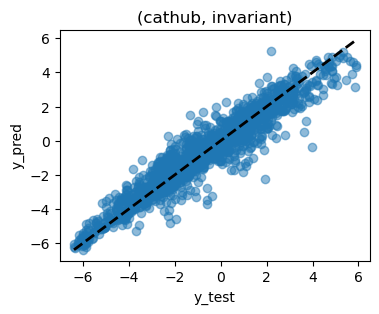

X_train shape: (8750, 1024), X_test shape: (2188, 1024)
y_train shape: (8750,), y_test shape: (2188,)
train to test ratio: 0.8:0.2
Mean Abs. Error: 0.45
R2-score: 0.91


In [12]:
X_train_invariant1 = model_invariant.encoder(torch.from_numpy(X_train1).float()).detach().numpy() 
X_test_invariant1 = model_invariant.encoder(torch.from_numpy(X_test1).float()).detach().numpy()

lr = 0.2
depth = 8
n_est = 500
model1 = xgb.XGBRegressor(learning_rate=lr, max_depth=depth, n_estimators=n_est)
model1.fit(X_train_invariant1, y_train1)

y_pred1 = model1.predict(X_test_invariant1)
mae1 = mean_absolute_error(y_test1, y_pred1)
r2score1 = r2_score(y_test1, y_pred1)

plt.figure(figsize=(4, 3))
plt.scatter(y_test1, y_pred1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title(f'(cathub, invariant)')
plt.plot([y_test1.min(), y_test1.max()], [y_test1.min(), y_test1.max()], 'k--', lw=2)
plt.show()
print(f'X_train shape: {X_train1.shape}, X_test shape: {X_test1.shape}')
print(f'y_train shape: {y_train1.shape}, y_test shape: {y_test1.shape}')
print(f'train to test ratio: {1-ratio_test}:{ratio_test}')
print(f'Mean Abs. Error: {mae1:.2f}')
print(f'R2-score: {r2score1:.2f}')

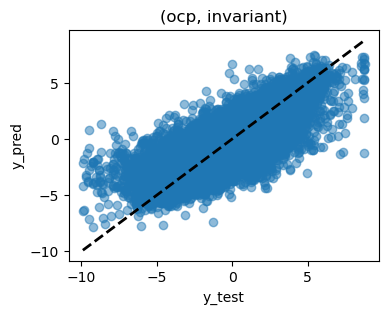

X_train shape: (263890, 1024), X_test shape: (65973, 1024)
y_train shape: (263890,), y_test shape: (65973,)
train to test ratio: 0.8:0.2
Mean Abs. Error: 0.85
R2-score: 0.68


In [13]:
X_train_invariant2 = model_invariant.encoder(torch.from_numpy(X_train2).float()).detach().numpy() 
X_test_invariant2 = model_invariant.encoder(torch.from_numpy(X_test2).float()).detach().numpy()

lr = 0.2
depth = 8
n_est = 500
model2 = xgb.XGBRegressor(learning_rate=lr, max_depth=depth, n_estimators=n_est)
model2.fit(X_train_invariant2, y_train2)

y_pred2 = model2.predict(X_test_invariant2)
mae2 = mean_absolute_error(y_test2, y_pred2)
r2score2 = r2_score(y_test2, y_pred2)

plt.figure(figsize=(4, 3))
plt.scatter(y_test2, y_pred2, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title(f'(ocp, invariant)')
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.show()
print(f'X_train shape: {X_train2.shape}, X_test shape: {X_test2.shape}')
print(f'y_train shape: {y_train2.shape}, y_test shape: {y_test2.shape}')
print(f'train to test ratio: {1-ratio_test}:{ratio_test}')
print(f'Mean Abs. Error: {mae2:.2f}')
print(f'R2-score: {r2score2:.2f}')